# UNET SEGMENTATION

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.4 Code

In [ ]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding
seed = 42
random.seed = seed
np.random.seed = seed
tf.seed = seed

## Data Generator

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".jpg"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)

        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))

        mask = np.zeros((self.image_size, self.image_size, 1))

        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)

        ## Normalizing
        image = image/255.0
        mask = mask/255.0

        return image, mask

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size

        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]

        image = []
        mask  = []

        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)

        image = np.array(image)
        mask  = np.array(mask)

        return image, mask

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

## Hyperparameters

In [ ]:
image_size = 640
train_path = "C:/Users/NIT/Downloads/FData123/"
epochs = 50
batch_size = 32

## Training Ids
train_ids = next(os.walk(train_path))[1]

## Validation Data Size
val_data_size = 52
print(len(train_ids))

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

258


In [ ]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(32, 640, 640, 3) (32, 640, 640, 1)


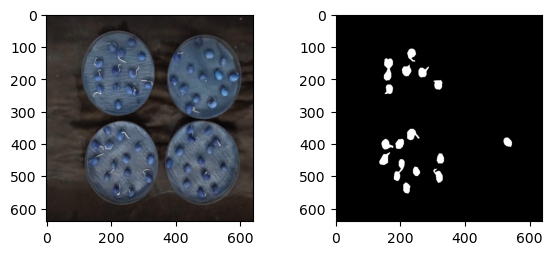

In [ ]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

## Different Convolutional Blocks

In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

## UNet Model

In [ ]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))

    p0 = inputs
    c1, p1 = down_block(p0, f[0])  # 128 --> 64
    c2, p2 = down_block(p1, f[1])  # 64  --> 32
    c3, p3 = down_block(p2, f[2])  # 32  --> 16
    c4, p4 = down_block(p3, f[3])  # 16  --> 8

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3])  # 8  --> 16
    u2 = up_block(u1, c3, f[2])  # 16 --> 32
    u3 = up_block(u2, c2, f[1])  # 32 --> 64
    u4 = up_block(u3, c1, f[0])  # 64 --> 128

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
image_size = 640
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 640, 640, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 640, 640, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 640, 640, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 320, 320, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

## Training the model

In [ ]:
from tensorflow.keras.callbacks import TensorBoard


train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

tensorboard_callback = TensorBoard(log_dir='C:/Users/NIT/Downloads', histogram_freq=1)


model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps,
                    validation_steps=valid_steps, epochs=epochs)

C:\Users\NIT\AppData\Local\Temp\ipykernel_12168\3737294343.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps,


Epoch 1/50
6/6 [==============================] - 141s 21s/step - loss: 0.5166 - acc: 0.9629 - val_loss: 0.2285 - val_acc: 0.9617
Epoch 2/50
6/6 [==============================] - 88s 15s/step - loss: 0.2049 - acc: 0.9617 - val_loss: 0.1874 - val_acc: 0.9597
Epoch 3/50
6/6 [==============================] - 86s 14s/step - loss: 0.1565 - acc: 0.9660 - val_loss: 0.1515 - val_acc: 0.9597
Epoch 4/50
6/6 [==============================] - 64s 11s/step - loss: 0.1326 - acc: 0.9645 - val_loss: 0.1206 - val_acc: 0.9597
Epoch 5/50
6/6 [==============================] - 57s 9s/step - loss: 0.1198 - acc: 0.9603 - val_loss: 0.1131 - val_acc: 0.9597
Epoch 6/50
6/6 [==============================] - 38s 6s/step - loss: 0.1057 - acc: 0.9636 - val_loss: 0.1092 - val_acc: 0.9597
Epoch 7/50
6/6 [==============================] - 37s 6s/step - loss: 0.1030 - acc: 0.9623 - val_loss: 0.1066 - val_acc: 0.9597
Epoch 8/50
6/6 [==============================] - 40s 7s/step - loss: 0.0944 - acc: 0.9657 - val_lo

## Testing the model

In [ ]:
## Save the Weights
model.load_weights("/content/drive/MyDrive/UNetWOG.h5")
image_size=640
import cv2

## Dataset for prediction

x = cv2.imread("/content/WhatsApp Image 2023-09-23 at 11.56.43 PM (1).jpeg")

x = cv2.resize(x,(640,640))
x=x/255.0
print(x.shape)
# x = x.reshape(8,640,640,3)

x = np.expand_dims(x, axis=0)
result = model.predict(x)

result = result > 0.3
cv2.imwrite("/content/resized_image.png", (result[0] * 255).astype(np.uint8))



(640, 640, 3)
1/1 [==============================] - 8s 8s/step


True

In [ ]:


import cv2
import numpy as np

# Load the binary image
image = cv2.imread('/content/resized_image.png', cv2.IMREAD_GRAYSCALE)
k = cv2.imread("/content/WhatsApp Image 2023-09-23 at 11.56.43 PM (1).jpeg",1)
k = cv2.resize(k,(640,640))
# k=k/255.0
# Convert the binary image to binary threshold using OpenCV thresholding
_, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Convert the binary image to 8-bit unsigned depth
binary_image = binary_image.astype(np.uint8)

# Perform connected component analysis
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

# Extract each seed region
seeds = []
for label in range(1, num_labels):  # Skip background label 0
    seed_region = np.where(labels == label, 255, 0).astype(np.uint8)
    seeds.append(seed_region)

# Save each seed region as a separate image
for i, seed in enumerate(seeds):
     masked_image = np.zeros((640, 640), dtype=np.uint8)


     masked_image = cv2.bitwise_or(k, k, mask=seed)
     print(seed.shape)


     contours, _ = cv2.findContours(seed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get the bounding box of the largest contour
     largest_contour = max(contours, key=cv2.contourArea)
     x, y, w, h = cv2.boundingRect(largest_contour)

# Crop the original image using the bounding box
     cropped_image = masked_image[y:y + h, x:x + w]
    #  cv2.rectangle(k, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Resize the cropped image to match the dimensions of the mask area
     resized_image = cv2.resize(cropped_image, (masked_image.shape[1]//2, masked_image.shape[0]//2))
        #resized_image = cv2.resize(cropped_image, (320,320))



     cv2.imwrite(f'/content/drive/MyDrive/QWERI/one3/seed_{i}.png', resized_image)


(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)
(640, 640)


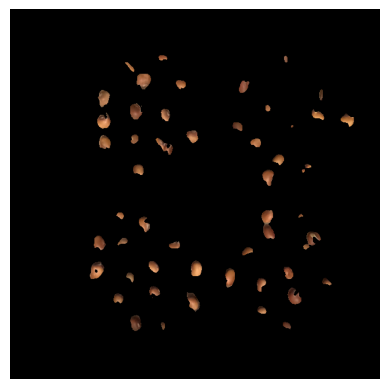

In [ ]:


import cv2
import numpy as np


image = cv2.imread('/content/resized_image.png', cv2.IMREAD_GRAYSCALE)
k = cv2.imread("/content/WhatsApp Image 2023-09-23 at 11.56.43 PM (1).jpeg",1)
k = cv2.resize(k,(640,640))

_, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)


binary_image = binary_image.astype(np.uint8)


num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

masked_image = np.zeros((640, 640), dtype=np.uint8)

masked_image = cv2.bitwise_or(k, k, mask=image)


cv2.imwrite(f'/content/seed_{i}.png', masked_image)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(f'/content/seed_{i}.png')
plt.imshow(img)
plt.axis('off')
plt.show()

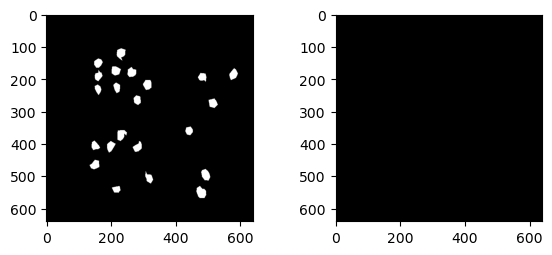

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")